# Clustering Analysis


## Geographical Clustering

1. We want to cluster the states based on the number of incidents per state. We will use the K-Means algorithm.
2. We can explore if some regions or states have similar incidents characteristics.

In [1]:
# This will take a while
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import plotly.offline as py


from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# for dataset visibility
pd.set_option('display.max_columns', None)

# Set a seed for reproducibility
np.random.seed(42)


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
df_merged_clustering = pd.read_hdf('../ds/cleaned/clustering.h5')
df_merged = pd.read_csv('../ds/cleaned/merged.csv')
# load the h5
df_merged_clustering_reduced = pd.read_hdf('../ds/cleaned/reduced_for_clustering.h5')


In [5]:
df_merged_clustering_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64553 entries, 0 to 134578
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   date                       64553 non-null  datetime64[ns]
 1   state                      64553 non-null  object        
 2   city_or_county             64553 non-null  object        
 3   latitude                   64553 non-null  float64       
 4   longitude                  64553 non-null  float64       
 5   congressional_district     64553 non-null  int64         
 6   participant_age_group1     64553 non-null  category      
 7   participant_gender1        64553 non-null  category      
 8   min_age_participants       64553 non-null  int64         
 9   n_participants_child       64553 non-null  int64         
 10  n_participants_teen        64553 non-null  int64         
 11  n_females                  64553 non-null  int64         
 12  n_k

# Feature selection for clustering

We will try more clusters from the indexes we gathered in previous analysis

In [6]:
# Initially we select all the


selected_features = df_merged_clustering_reduced[['percentage_injured', 'unharmed_ratio',
                                                  'males_to_females_ratio', 
                                                  'totalvotes', 'povertyPercentage',
                                                  'density_incident_state', 'n_arrested', 'min_age_participants']]

selected_features_demographic = df_merged_clustering_reduced[['min_age_participants', 'n_arrested', 'density_incident_state']]

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(selected_features)

In [7]:
selected_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64553 entries, 0 to 134578
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   percentage_injured      64553 non-null  float64
 1   unharmed_ratio          64553 non-null  float64
 2   males_to_females_ratio  64553 non-null  float64
 3   totalvotes              64553 non-null  float64
 4   povertyPercentage       64553 non-null  float64
 5   density_incident_state  64553 non-null  float64
 6   n_arrested              64553 non-null  int64  
 7   min_age_participants    64553 non-null  int64  
dtypes: float64(6), int64(2)
memory usage: 4.4 MB


In [9]:

#entropy of each feature
from scipy.stats import entropy
for col in selected_features.columns:
    print(col, entropy(selected_features[col].value_counts(normalize=True)))


percentage_injured 3.4434299246295352
unharmed_ratio 0.9414124184777405
males_to_females_ratio 1.1986138495333811
totalvotes 6.574008227991281
povertyPercentage 3.899149612928058
density_incident_state 3.4434299246295352
n_arrested 0.8518728360201842
min_age_participants 3.7509132628675017


100%|██████████| 9/9 [00:13<00:00,  1.46s/it]


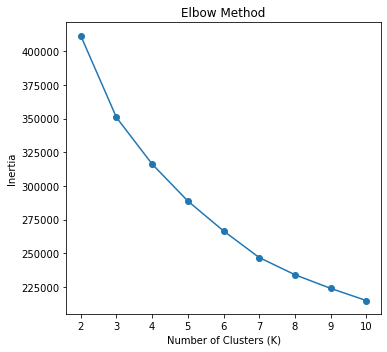

In [10]:
# Determine the optimal number of clusters using the Elbow Method
inertia = []
silhouette_scores = []

for k in tqdm(range(2, 11)):
    kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++', n_init=10, max_iter=100)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)
    #silhouette_scores.append(silhouette_score(scaled_data, kmeans.labels_))

# Plot the Elbow Method
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(2, 11), inertia, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method')

plt.tight_layout()
plt.show()

In [16]:
# Choose the optimal K and fit the KMeans model
optimal_k = 10 # Adjust based on your analysis
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
#sample same data as above
df_merged = df_merged_clustering_reduced.copy()
df_merged['cluster'] = kmeans.fit_predict(scaled_data)

/home/vincent/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



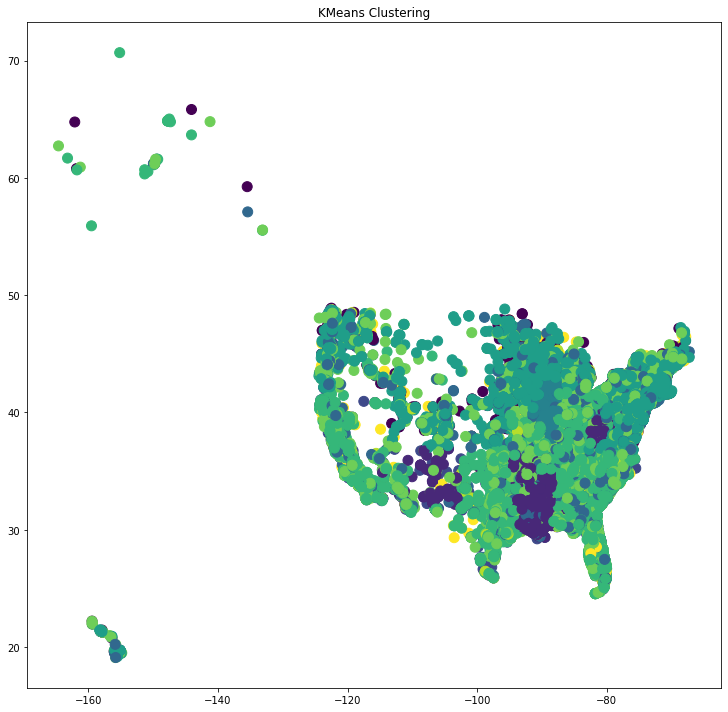

In [17]:
# Example: Scatter plot for two features
# bigger plot
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
# longitude and latitude
plt.scatter(df_merged['longitude'], df_merged['latitude'], c=df_merged['cluster'], cmap='viridis', s=100)
plt.title('KMeans Clustering')
plt.tight_layout()
plt.show()


In [18]:
SILHOUETTE = False

def perform_clustering(df, columns):
    X = df[columns].values 

    # Standardize the features (important for KMeans)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # We will try different number of clusters from 2 to 10
    n_clusters = np.arange(2, 11)

    inertia_scores = []
    kmeans_models = []
    silhouette_scores = []

    # For each number of clusters
    for n in tqdm(n_clusters):
        # Initialize the KMeans model with n_clusters=n
        # Use KMenans++ initialization for faster convergence
        kmeans = KMeans(n_clusters=n, random_state=42,
                        n_init=10, max_iter=10, algorithm='lloyd', init='k-means++')

        # Fit the model
        kmeans.fit(X_scaled)
        print("Current model:", kmeans)
        
        # Get the inertia score
        inertia_scores.append(kmeans.inertia_)
        print("Current inertia score:", kmeans.inertia_)
        print("")
      
        if SILHOUETTE:
            # get silhouette score
            silhouette_avg = silhouette_score(X_scaled, kmeans.labels_)
            silhouette_scores.append(silhouette_avg)
            print("Current silhouette score:", silhouette_avg)
            print("") 
            
        # Store the model
        kmeans_models.append(kmeans)

    return kmeans_models, inertia_scores

#
def elbow_plot(n_clusters, inertia_scores, columns):
    # Plot the elbow curve
    plt.figure(figsize=(10, 6))
    plt.plot(n_clusters, inertia_scores, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia score')
    plt.title('Elbow curve of variables: {}'.format(columns))
    plt.show()
    
def silhouette_plot(n_clusters, silhouette_scores, columns):
    # Plot the silhouette scores
    plt.figure(figsize=(10, 6))
    plt.plot(n_clusters, silhouette_scores, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette score')
    plt.title('Silhouette curve of variables: {}'.format(columns))
    plt.show()
    

# Single Variable Clustering:

By performing clustering on each variable individually to understand the inherent structure within each variable. This might provide insights into patterns within each variable separately.

Well we know some variables are clustered in omogeneous way, for example incident participant we can see how they are clustered by state.



In [ ]:
# Using the predefined function to perform clustering on each variable and storing the different models in a list
models = []
# take only columns with numeric values
numeric_columns = df_merged_clustering.select_dtypes(include=[np.number]).columns

df_subset = df_merged_clustering[numeric_columns]
#take n samples : be careful quadratic in number of samples

## Clustering more specific things

In [ ]:
# We have latitude, longitude, n_killed, povertyPercentage: so we can clusterize 
# these 4 variables obtaining a feature selection that reduces the dimensionality

# select colums from df_merged_clustering that are named as follows :  'n_killed', 'poveryPercentage'
columns = ['povertyPercentage', 'n_killed', 'n_injured', 'n_arrested', 'n_unharmed']
selected_columns = df_subset 

scaler = StandardScaler()
selected_columns_scaled = scaler.fit_transform(selected_columns)
# perform clustering on the selected columns
cluster_povery_danger = perform_clustering(selected_columns, columns)


### Elbow plot vs Silhouette plot

In [ ]:
elbow_plot(np.arange(2, 11), cluster_povery_danger[1], columns)

## Silohuette plot
The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters

In [ ]:
silhouette_plot(np.arange(2, 11), cluster_povery_danger[3], columns)

In [ ]:
# Let's try 5 clusters
# take the model with 5 clusters
kmeans = cluster_povery_danger[0][2]


# visualize the clusters
# Create a scatter plot of the Latitude vs Longitude
plt.figure(figsize=(10, 6))
plt.scatter(df_subset['longitude'], df_subset['latitude'], c=kmeans.labels_, cmap='viridis')
# adding centroids
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Clustering of povertyPercentage')
plt.show()



# Alternatively Silhouette score

# Clustering visualizations

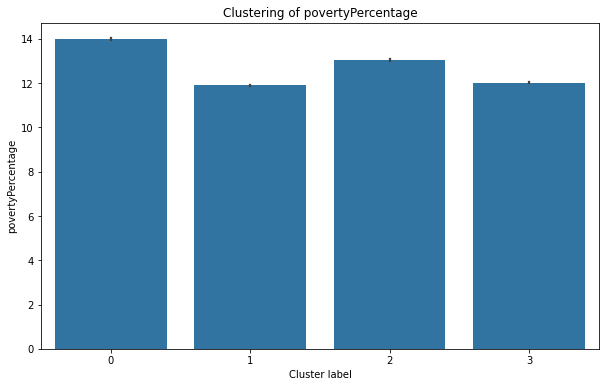

In [51]:
# Clustering visualization of males_to_females_ratio

# Take the model with 4 clusters
kmeans = cluster_povery_danger[0][2]

# Create a barplot of the clusters
plt.figure(figsize=(10, 6))
sns.barplot(x=kmeans.labels_, y=df_subset['povertyPercentage'])
plt.xlabel('Cluster label')
plt.ylabel('povertyPercentage')
plt.title('Clustering of povertyPercentage')
plt.show()
